# Setting up the VAE environment in PyTorch

In [11]:
import torch  
import torch.nn as nn  
import torch.optim as optim  
from torchvision import datasets, transforms  
from torch.utils.data import DataLoader  
import torch.nn.functional as F 
import numpy as np  
import matplotlib.pyplot as plt  
 
# Use GPU if available  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load MNIST dataset  
transform = transforms.ToTensor()  
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)  
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True) 


# Building the VAE model architecture in PyTorch

## Building the encoder class 
The encoder takes an input image, compresses it into a compact latent representation, and outputs two vectors: the mean (μ) and log-variance (logσ²). These vectors define a probability distribution that will later be used to sample a latent vector, rather than generating a single fixed point like a traditional autoencoder.

In [12]:
class Encoder(nn.Module):  
  def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):  
    super(Encoder, self).__init__()  
    self.fc1 = nn.Linear(input_dim, hidden_dim)  
    self.fc_mu = nn.Linear(hidden_dim, latent_dim)  
    self.fc_logvar = nn.Linear(hidden_dim, latent_dim) 

  def forward(self, x): 
    h = torch.relu(self.fc1(x)) 
    mu = self.fc_mu(h) 
    logvar = self.fc_logvar(h) 
    return mu, logvar 


## Implementing the decoder class
The decoder reverses the process, taking a sampled latent vector and attempting to reconstruct the original image. Through this process, the VAE learns to generate new data that resembles the training inputs.

In [13]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=20, hidden_dim=400, output_dim=784):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = torch.relu(self.fc1(z))
        logits = self.fc2(h)          # <- logits (no sigmoid here)
        return logits

## Creating the main VAE class
The VAE class integrates the encoder and decoder, utilizing the reparameterization trick to maintain differentiability during training. To enable backpropagation through the sampling process, we sample ε from a standard normal distribution N(0,1) and calculate z as μ + σ * ε, rather than directly sampling from the latent distribution.

The reparameterize() function enables differentiable sampling.

 - logvar is exponentiated and scaled to get the standard deviation.
 - eps is random noise from a standard normal distribution.
 - The final sampled z has the desired mean and variance but is differentiable with respect to mu and logvar.
The model outputs the reconstruction along with mu and logvar for computing the loss.

In [14]:
class VAE(nn.Module):  
  def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):  
    super(VAE, self).__init__()  
    self.encoder = Encoder(input_dim, hidden_dim, latent_dim)  
    self.decoder = Decoder(latent_dim, hidden_dim, input_dim)  
 
  def reparameterize(self, mu, logvar):  
    std = torch.exp(0.5 * logvar)   # Standard deviation  
    eps = torch.randn_like(std)    # Random noise  
    return mu + eps * std                 # Sample from the latent distribution  

  def forward(self, x):  
    mu, logvar = self.encoder(x)  
    z = self.reparameterize(mu, logvar)  
    reconstructed = self.decoder(z)  
    return reconstructed, mu, logvar 


## Step 3: Defining the loss function – Reconstruction + KL divergence
Reconstruction loss: Ensures the output is close to the original input.

 - KL divergence: Encourages the learned latent distribution to be close to a standard normal distribution.

 - The total loss is often referred to as the ELBO (Evidence Lower Bound), and we aim to maximize it (or equivalently, minimize its negative).

In [15]:
def loss_function(logits, x, mu, logvar, beta=1.0):
    recon_loss = F.binary_cross_entropy_with_logits(logits, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl, recon_loss, kl

## Step 4: Training and evaluating the VAE
With the VAE model and loss function defined, we can proceed to training. We'll execute the training loop for multiple epochs, track the loss, and visualize the model's reconstruction and generation capabilities as it learns.

Epoch 1, Loss: 163.0763
Epoch 2, Loss: 120.1761
Epoch 3, Loss: 113.3949
Epoch 4, Loss: 110.5760
Epoch 5, Loss: 108.9781
Epoch 6, Loss: 107.8964
Epoch 7, Loss: 107.0917
Epoch 8, Loss: 106.5772
Epoch 9, Loss: 106.0614
Epoch 10, Loss: 105.7079
Epoch 11, Loss: 105.3669
Epoch 12, Loss: 105.0863
Epoch 13, Loss: 104.8647
Epoch 14, Loss: 104.6505
Epoch 15, Loss: 104.4276
Epoch 16, Loss: 104.2593
Epoch 17, Loss: 104.0647
Epoch 18, Loss: 103.9197
Epoch 19, Loss: 103.8085
Epoch 20, Loss: 103.6662


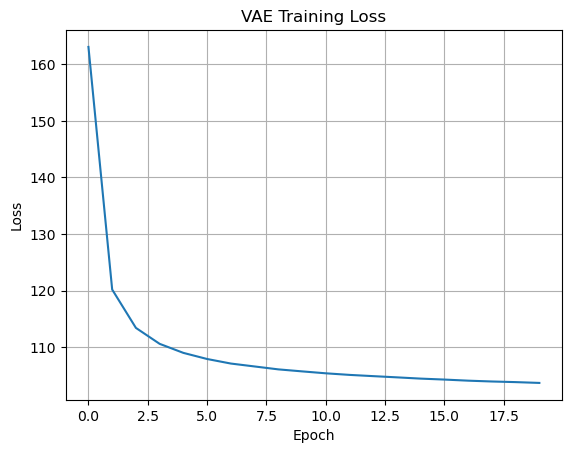

In [21]:
import matplotlib.pyplot as plt 

# Set training parameters 
epochs = 20  
learning_rate = 1e-3  

# Initialize model, optimizer 
model = VAE().to(device)  
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))

# Track losses 
train_losses = [] 

# Training loop
model.train()  

for epoch in range(epochs):  
  total_loss = 0
  for batch_idx, (x, _) in enumerate(train_loader):  
    x = x.view(-1, 784).to(device)  # Flatten images 
    optimizer.zero_grad() 

    recon_logits, mu, logvar = model(x) 
    recon_x = torch.sigmoid(recon_logits)
    loss, recon_loss, kl_loss = loss_function(recon_logits, x, mu, logvar)
    loss.backward()
    optimizer.step() 
     
    total_loss += loss.item() 
 
  avg_loss = total_loss / len(train_loader.dataset) 
  train_losses.append(avg_loss) 
  print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}") 

 

# Plotting the training loss 
plt.plot(train_losses) 
plt.title("VAE Training Loss") 
plt.xlabel("Epoch") 
plt.ylabel("Loss") 
plt.grid(True) 
plt.show() 


## Step 5: Testing the VAE by generating new samples
Once the VAE is trained, we can evaluate its generative capabilities by sampling from the learned latent space and observing the outputs

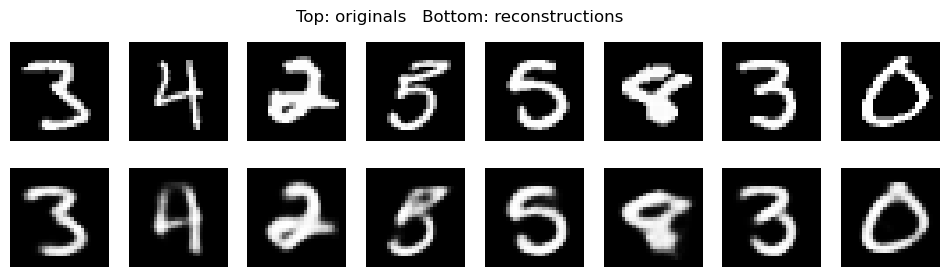

VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=784, out_features=400, bias=True)
    (fc_mu): Linear(in_features=400, out_features=20, bias=True)
    (fc_logvar): Linear(in_features=400, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=20, out_features=400, bias=True)
    (fc2): Linear(in_features=400, out_features=784, bias=True)
  )
)

In [23]:
model.eval()
with torch.no_grad():
    x, _ = next(iter(train_loader))
    x = x[:8].to(device)
    logits, _, _ = model(x.view(-1, 784))
    recon = torch.sigmoid(logits).view(-1, 1, 28, 28).cpu()

fig, axs = plt.subplots(2, 8, figsize=(12, 3))
for i in range(8):
    axs[0, i].imshow(x[i].view(28,28).cpu(), cmap='gray'); axs[0, i].axis('off')
    axs[1, i].imshow(recon[i,0], cmap='gray');             axs[1, i].axis('off')
plt.suptitle("Top: originals   Bottom: reconstructions"); plt.show()
model.train()
